# Partition Sphere into Flat Regions and Project into Flat Space
Two options:

1. Invoke spherical wavelets
2. Apply standard 2D wavelets in small patches of the sky

We consider the second approach, as it allows us to implement our current code for flat wavelets and gives us greater freedom to parallelize the code and optimize our wavelet scales with respect to the background at each pixel. 

## Partition Sphere via HEALPix Scheme
Suppose we have a sample of photon counts across the whole sky, ignoring energy. To use the flat CWT for point source detection, the main idea is to decompose the sky into small patches, so that the difference between the difference between the Euclidean and angular diameter distance between two points in any given patch is negligible. As in arXiv:0212578, we define our patches using the HEALPIX scheme. Specifically, we partition the sky into 192, $\sim 10^{\circ}$ *father pixels* by setting NSIDE = 4.

The edges of these pixels are returned by the `healpix_edge_generator_` function in the `_maps` utility module.

In [2]:
import sys, os, time, fileinput
sys.path.append("..")
from utils import _maps as maps
from utils import _wavelets as wt

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
from scipy.integrate import quad
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('default') 

import healpy as hp
import astropy as ap
import astropy.units as u
from astropy_healpix import HEALPix

In [3]:
# set the number of pixels in the map
NSIDE = 4
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)
NPIX = hp.nside2npix(NSIDE)
print("Number of Pixels: {}".format(NPIX))

# after loading the data, all we need to do is be sure the angular coordinates are written in terms
# of longitude ([0,2\pi]) and latitude (-\pi, \pi)
## source: gce/notebooks/sections_of_sphere_to_plane_v2

# generate random points on plane around a pixel and see detect points inside it
# project boundaries into square region in plane tangent to center point

arr_edge_points = maps.healpix_edge_generator_(NSIDE = 4, step = 100)
arr_c = maps.father_pixel_center_generator_(arr_edge_points)

Approximate resolution at NSIDE 4 is 1.5e+01 deg
Number of Pixels: 192


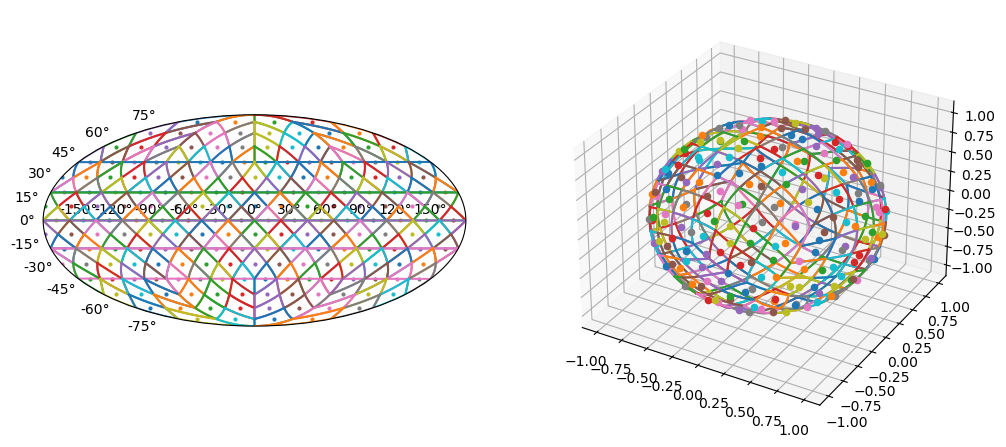

In [7]:
fig = plt.figure(1,figsize=(12,6))
ax1 = fig.add_subplot(121, projection='mollweide')
ax2 = fig.add_subplot(122, projection='3d')

for npix in range(NPIX):
    # plot healpix pixels in Mollweide projection
    ax1.plot(arr_edge_points[npix, :, 0] - np.pi, arr_edge_points[npix, :, 1])
    ax1.scatter(arr_c[npix, 0] - np.pi, arr_c[npix, 1], s = 4)

    # plot healpix pixels in 3D
    x,y,z = hp.boundaries(NSIDE, npix, 100)
    ax2.plot(x,y,z)
    
    lat_c, lon_c = hp.pix2ang(NSIDE, npix)
    x_c = np.sin(lat_c) * np.cos(lon_c)
    y_c = np.sin(lat_c) * np.sin(lon_c)
    z_c = np.cos(lat_c) 
    ax2.scatter(x_c, y_c, z_c)

The HEALPix pixels are numbered using the RING scheme as shown in Fig. 3 of the [HEALPix Primer](https://healpix.jpl.nasa.gov/pdf/intro.pdf). We attach the numbering scheme here:

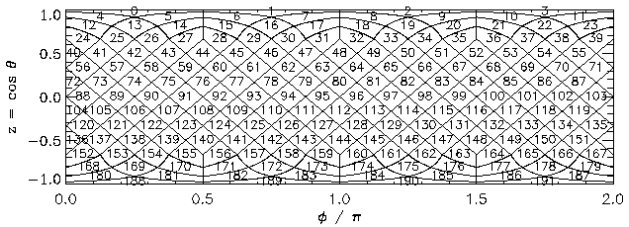. 

Notice that pixels `40,72,104,136` are disconnected. We take this into account when grouping datapoints by the father pixel that they occupy. See `find_points_inside_pixel_` for more details in the `_maps` utility module.

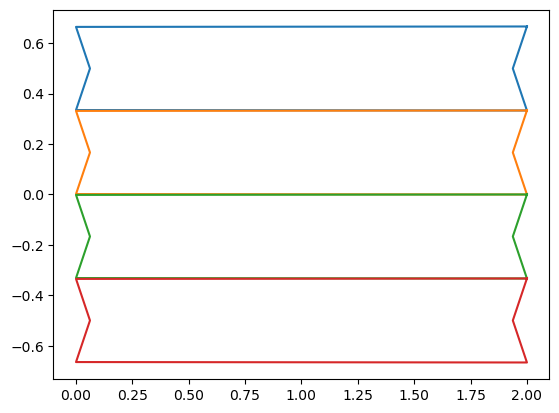

In [8]:
for npix in [40,72,104,136]:
    lon = arr_edge_points[npix, :, 0] ; lat = arr_edge_points[npix, :, 1]
    lat = np.pi/2 - lat

    plt.plot(lon / np.pi, np.cos(lat))

## Projecting Father Pixels and Datapoints
We project via the tangent plane projection. That is, datapoints are projected into the tangent plane lying in the center of the father pixel that they occupy. For derivation and more details, see `extra/tangent_plane_projection`. This projection is performed by the `tangent_plane_proj_` function in the `_maps` utility module.

### Project Father Pixel

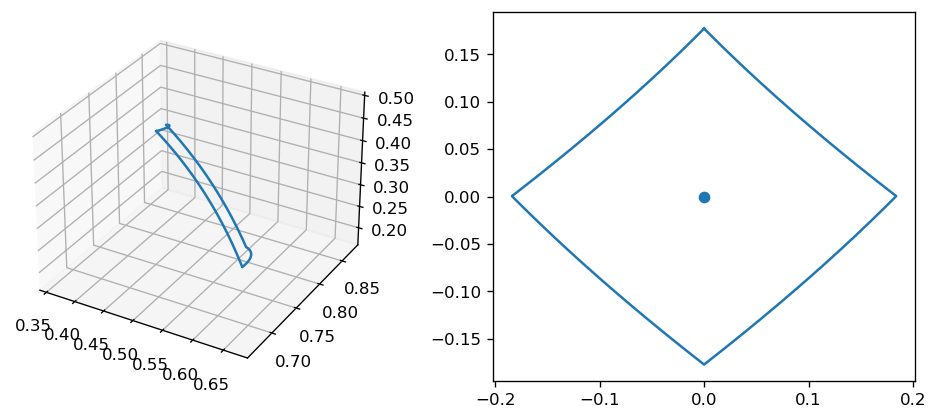

In [11]:
npix = 58

# extract latitudes and longitudes
lon_edge = arr_edge_points[npix, :, 0] ; lat_edge = arr_edge_points[npix, :, 1]
lon_c = arr_c[npix, 0] ; lat_c = arr_c[npix, 1]

# project boundaries into flat region in plane tangent to center point
r_edge = maps.tangent_plane_proj_(lat_edge, lon_edge, lat_c, lon_c)
x_edge = r_edge[:,0] ; y_edge = r_edge[:,1]

# plot the pixel and projection
fig = plt.figure(figsize=(10, 4), dpi= 120)

ax = fig.add_subplot(121, projection='3d')
x,y,z = hp.boundaries(NSIDE, npix, 100)
ax.plot(x,y,z)

ax = fig.add_subplot(122)
plt.plot(x_edge, y_edge)
plt.scatter(0, 0)

### Load Data

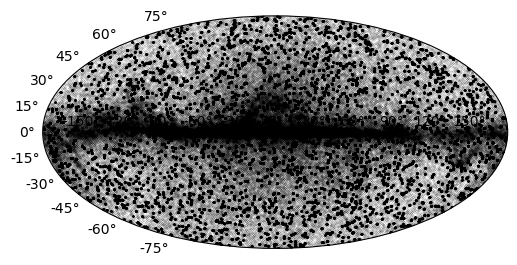

In [14]:
# load local directory
map_dir = "../data/maps/bkgd_wps_0/"

events = np.load(map_dir + 'map.npy', allow_pickle = True)
l_events = events[:,0]
b_events = events[:,1]

phi_events = l_events.copy()
phi_events[phi_events>np.pi] = phi_events[phi_events>np.pi]-2*np.pi

fig = plt.figure(1,figsize=(6,6))
ax = fig.add_subplot(111, projection='mollweide')
ax.scatter(phi_events,b_events, s = 0.01, c = 'k', alpha = 0.5)
plt.show()


### Find Points within Father Pixel
This is performed using the `find_points_inside_curve_` function in the `_maps` utility module. It works with the `Path` class from `matplotlib.path` via `.contains_points` to find the points inside a closed curve. 

In [15]:
npix = 58

# data needs to be in same coordinate system as pixels
lon_events = phi_events + np.pi
lat_events = b_events

# find points inside pixel
lon_pix, lat_pix = maps.find_points_inside_pixel_(lon_events, lat_events, npix, lon_edge, lat_edge, NSIDE=4, step=100)

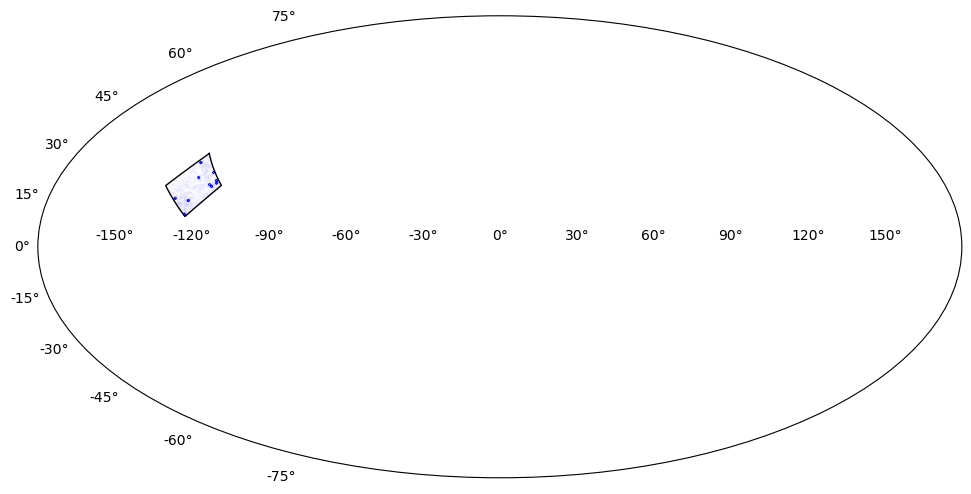

In [17]:
# plot patch and points in Mollweide projection
phi_pix = lon_pix - np.pi
phi_edge = lon_edge - np.pi

fig = plt.figure(1,figsize=(12,6))
ax = fig.add_subplot(111, projection='mollweide')

ax.scatter(phi_pix,lat_pix, s = 0.001, c = 'b', alpha = 0.5)
ax.plot(phi_edge, lat_edge, c = 'k', lw = 1)

### Project Datapoints to the Tangent Plane
This goes exactly as for the father pixel because the tangent plane has already been defined by the father pixel's center.

Text(0, 0.5, '$y$ (rad)')

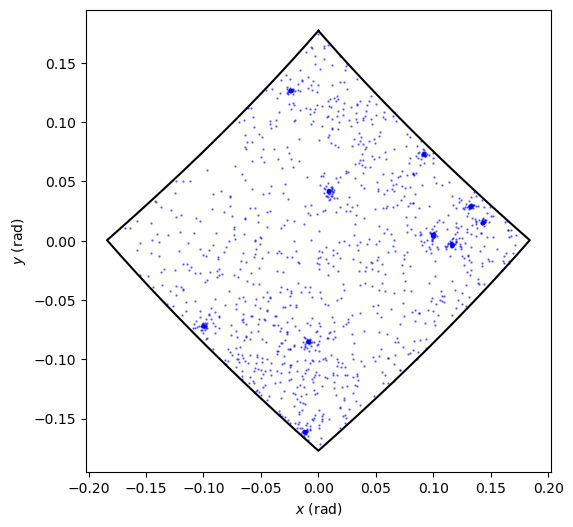

In [18]:
# project datapoints into flat region in plane tangent to center point
r_pix = maps.tangent_plane_proj_(lat_pix, lon_pix, lat_c, lon_c)
x_pix = r_pix[:,0] ; y_pix = r_pix[:,1]

fig = plt.figure(1,figsize=(6,6))
ax = fig.add_subplot(111)

ax.scatter(x_pix,y_pix, c = 'b', alpha = 0.5, s = 0.5)
ax.plot(x_edge,y_edge, c = 'k')
ax.set_xlabel('$x$ (rad)')
ax.set_ylabel('$y$ (rad)')